In [19]:
import numpy as np
import gym
import seaborn as sns
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning
from hiive.mdptoolbox.example import forest
import matplotlib.pyplot as plt
import time
import pickle
from pprint import pprint
from matplotlib.colors import ListedColormap

In [2]:
def plot_policy(policy_arrs, iterations, nbr_states=400):
    
    if len(policy_arrs) == 1:
        rows = 1
        cols = 2
    else:
        rows = len(policy_arrs) // 5
        rows = rows + 1 if len(policy_arrs) % 5 else rows
        cols = 5
        
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5,rows*8)) 
    for iteration, ax, policy_arr in zip(iterations, axes.ravel(), policy_arrs):
        
        labels = np.where(policy_arr==0, 'W', 'C')
        nbr_rows = int(np.sqrt(nbr_states))
        nbr_cols = int(np.sqrt(nbr_states))
        
        sns.heatmap(policy_arr.reshape(nbr_rows, nbr_cols), 
                 linewidth=0.5, 
                 annot=labels.reshape(nbr_rows, nbr_cols),
                 fmt = '',
                 cbar=False,
                 ax=ax)
        
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        ax.title.set_text(f'policy at iteration {iteration}')
        
    fig.tight_layout()
    plt.suptitle('Policies against iterations')
    plt.subplots_adjust(top=0.9)
    plt.show()

### Set up matrices for pymdptoolbox

In [3]:
transitions, reward_arr = mdptoolbox.example.forest(S=400, r1=100, r2=50, p=0.1)

### Value iteration

In [4]:
val_iter_perf_dict = {}
gamma_list = [0.3, 0.5, 0.7, 0.9, 0.99]
epsilon_list = [0.001, 0.0001, 0.00001]
best_score = 0
for gamma in gamma_list:
    for epsilon in epsilon_list:
        experiment_id = f'gamma={gamma}_epsilon={epsilon}'
        value_iteration_mdp = mdptoolbox.mdp.ValueIteration(transitions, reward_arr, gamma = gamma, epsilon = epsilon)
        value_iteration_mdp.run()
        state_val_arr = np.asarray(value_iteration_mdp.V)
        policy_arr = np.asarray(value_iteration_mdp.policy)
        iterations_taken = value_iteration_mdp.iter
        time_taken = value_iteration_mdp.time
        max_v = value_iteration_mdp.run_stats[-1]['Max V']
        summary = experiment_id + f', Value iteration took {iterations_taken} iterations and {round(time_taken, 5)} seconds, achieved {round(max_v, 2)} max value'
        print(summary)
        
        experiment_dict = {}
        experiment_dict['state_val_arr'] = state_val_arr
        experiment_dict['policy_arr'] = policy_arr
        experiment_dict['iterations_taken'] = iterations_taken
        experiment_dict['time_taken'] = time_taken
        experiment_dict['score'] = max_v
        experiment_dict['p_cumulative'] = value_iteration_mdp.p_cumulative
        experiment_dict['error_mean'] = value_iteration_mdp.error_mean
        experiment_dict['run_stats'] = value_iteration_mdp.run_stats
        val_iter_perf_dict[experiment_id] = experiment_dict
        
        with open('forest_val_iter_output.txt', 'a') as f:
            f.write(summary)

        with open('forest_val_iter_dict.pickle', 'wb') as handle:
            pickle.dump(val_iter_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        if max_v > best_score:
            best_score = max_v
            best_params = experiment_id
        
print(f'best params are {best_params}')

gamma=0.3_epsilon=0.001, Value iteration took 9 iterations and 0.00165 seconds, achieved 137.0 max value
gamma=0.3_epsilon=0.0001, Value iteration took 10 iterations and 0.00149 seconds, achieved 137.0 max value
gamma=0.3_epsilon=1e-05, Value iteration took 12 iterations and 0.00186 seconds, achieved 137.0 max value
gamma=0.5_epsilon=0.001, Value iteration took 15 iterations and 0.00249 seconds, achieved 181.87 max value
gamma=0.5_epsilon=0.0001, Value iteration took 18 iterations and 0.00265 seconds, achieved 181.87 max value
gamma=0.5_epsilon=1e-05, Value iteration took 21 iterations and 0.00317 seconds, achieved 181.87 max value
gamma=0.7_epsilon=0.001, Value iteration took 27 iterations and 0.01118 seconds, achieved 270.51 max value
gamma=0.7_epsilon=0.0001, Value iteration took 32 iterations and 0.00486 seconds, achieved 270.51 max value
gamma=0.7_epsilon=1e-05, Value iteration took 37 iterations and 0.00579 seconds, achieved 270.51 max value
gamma=0.9_epsilon=0.001, Value iterati

Value iteration achieved 952.47 max value and 0.09686 seconds


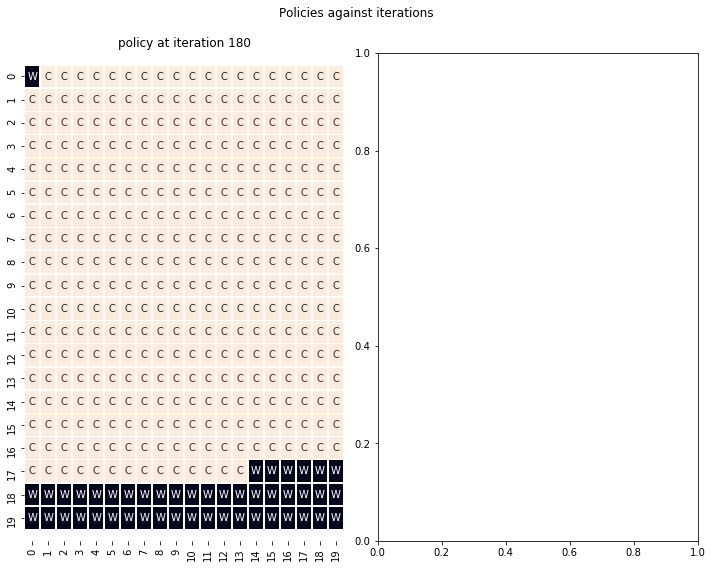

In [5]:
state_val_arr = val_iter_perf_dict[best_params]['state_val_arr']
policy_arr = val_iter_perf_dict[best_params]['policy_arr']
iterations_taken = val_iter_perf_dict[best_params]['iterations_taken']
time_taken = val_iter_perf_dict[best_params]['time_taken']
max_v = val_iter_perf_dict[best_params]['run_stats'][-1]['Max V']
print(f'Value iteration achieved {round(max_v, 2)} max value and {round(time_taken, 5)} seconds')
plot_policy([policy_arr], [iterations_taken])

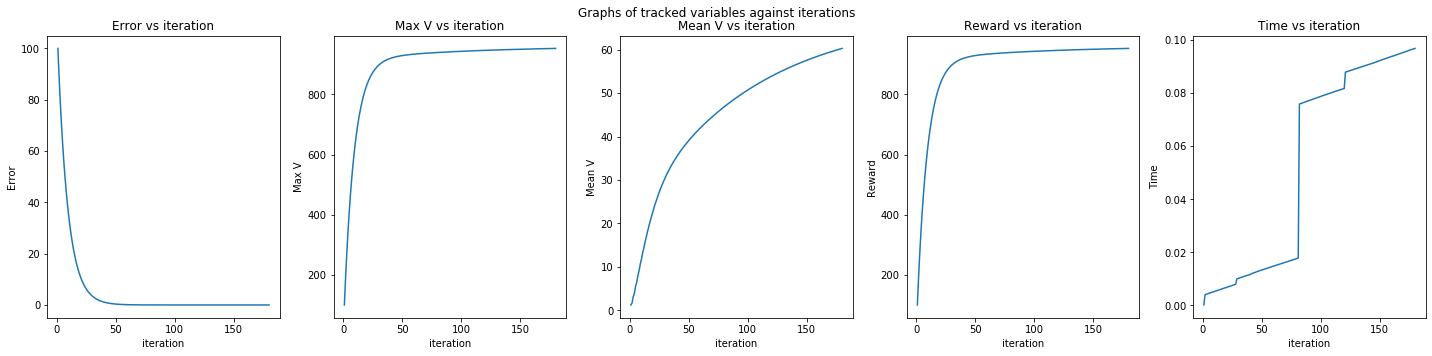

In [6]:
stats_list = val_iter_perf_dict[best_params]['run_stats']
graphs = ['Error', 'Max V', 'Mean V', 'Reward', 'Time']
fig, axes = plt.subplots(1,5, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    iterations_list = [stats['Iteration'] for stats in stats_list]
    variable_list = [stats[graph] for stats in stats_list]
    ax.plot(iterations_list, variable_list, label=graph)
    ax.title.set_text(f'{graph} vs iteration')
    ax.set_xlabel('iteration')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Graphs of tracked variables against iterations')
plt.subplots_adjust(top=0.9)
plt.show()

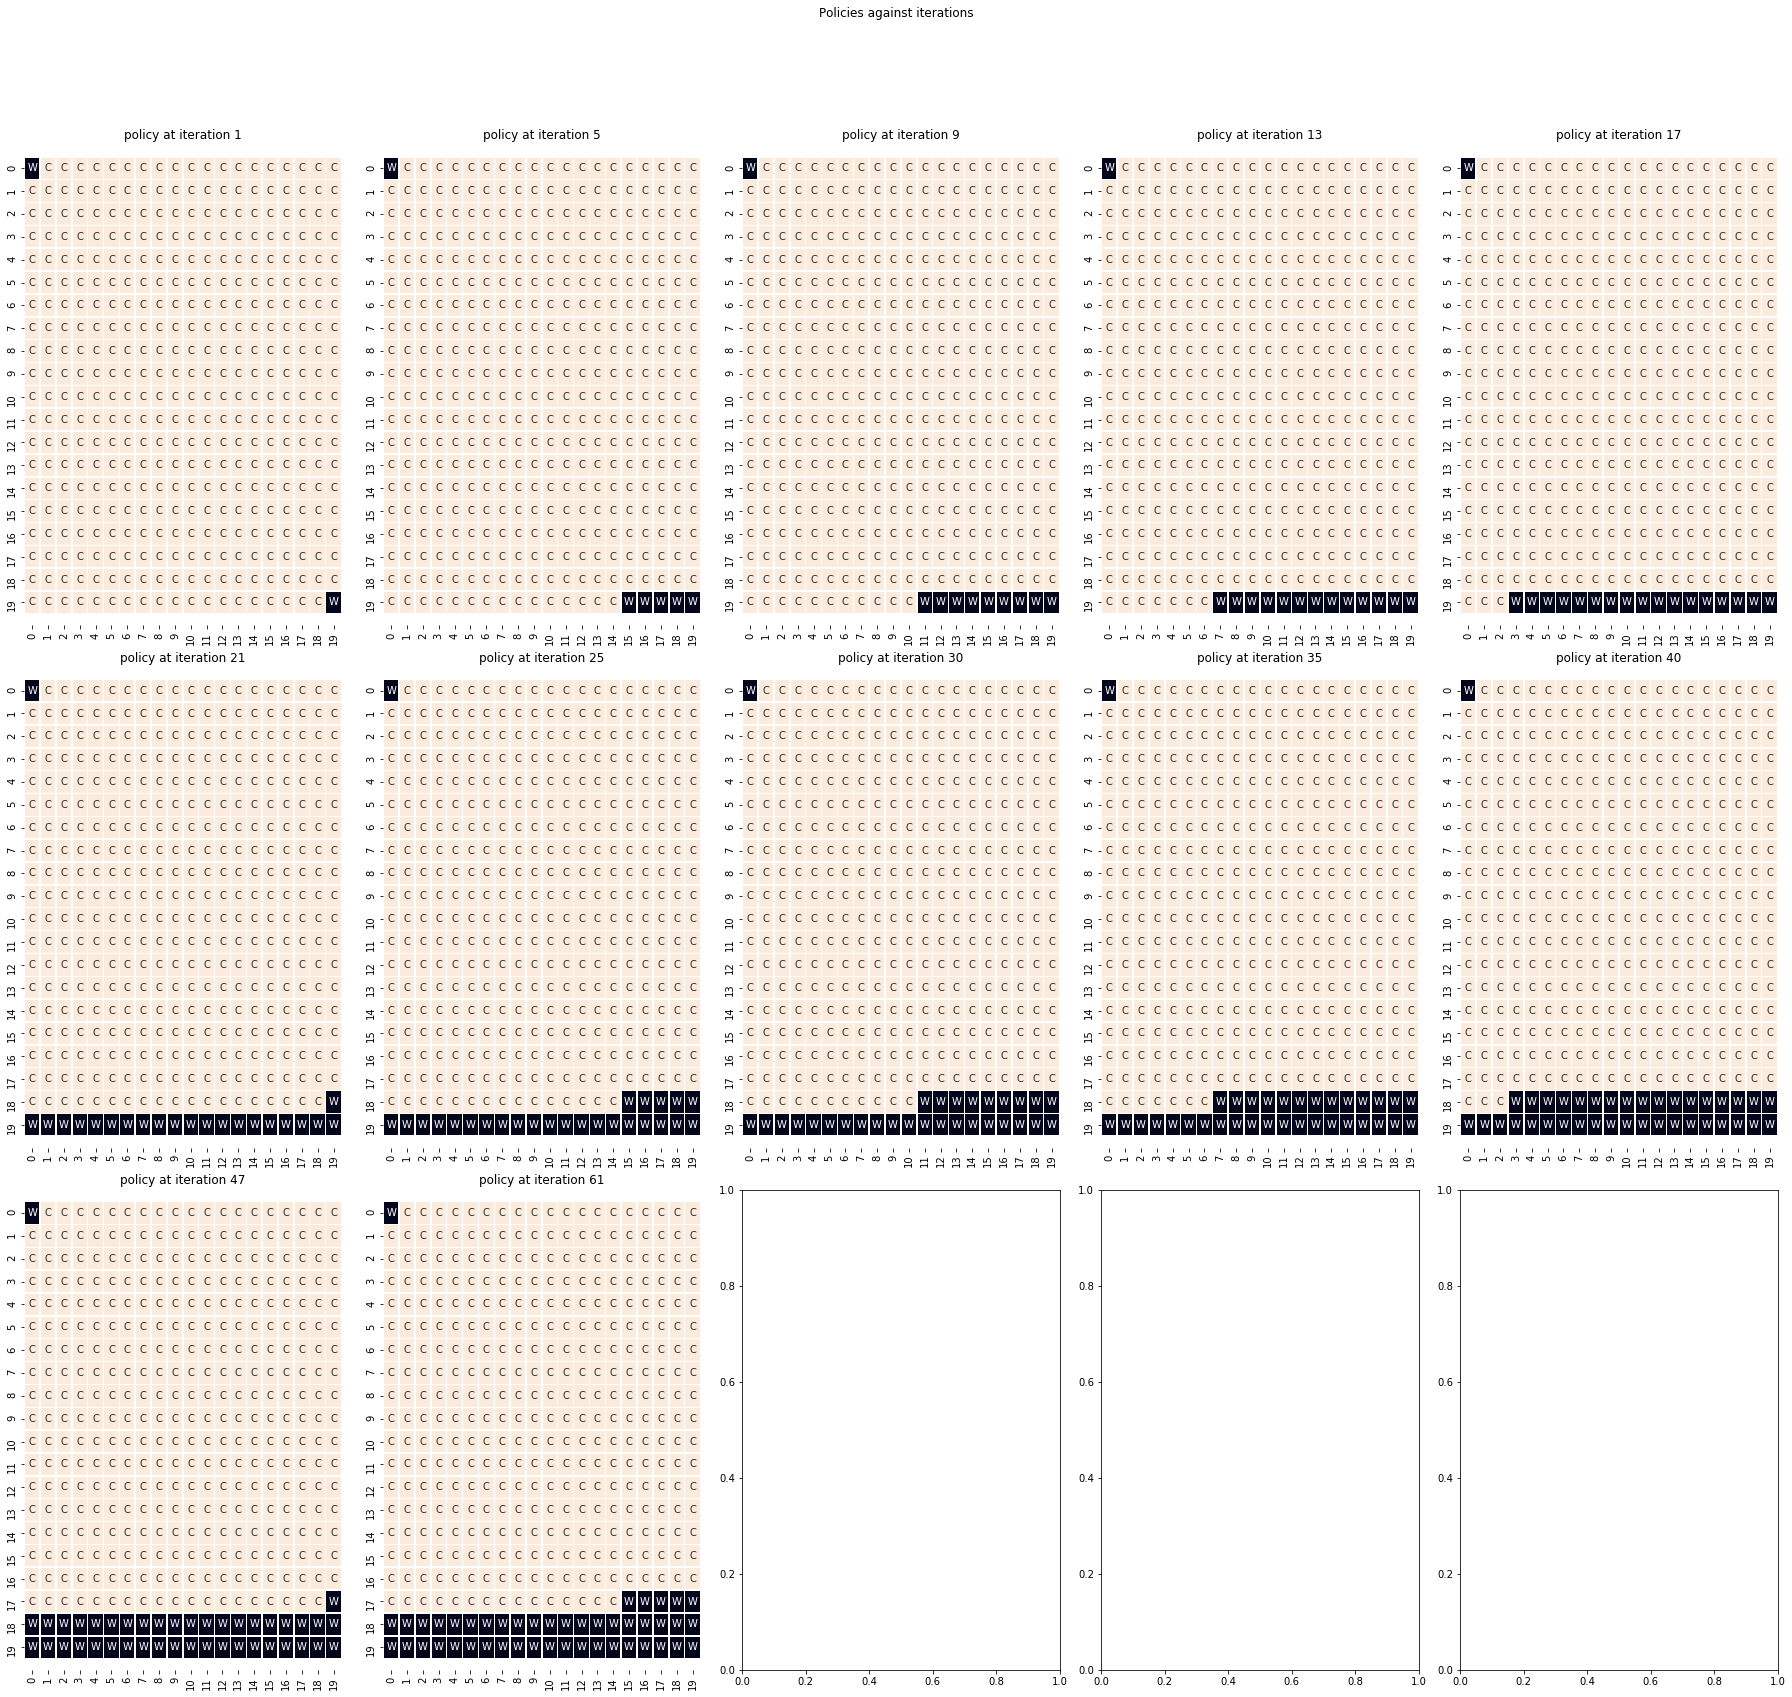

In [7]:
p_cumulative = val_iter_perf_dict[best_params]['p_cumulative']
length = len(p_cumulative)
every_n = 1 if length // 10 == 0 else length // 10
iterations = []
policy_arrs = []
for idx, p_cum in enumerate(p_cumulative):
    if idx % every_n > 0:
        continue
    iterations.append(p_cum[0])
    policy_arrs.append(p_cum[1])
plot_policy(policy_arrs, iterations)

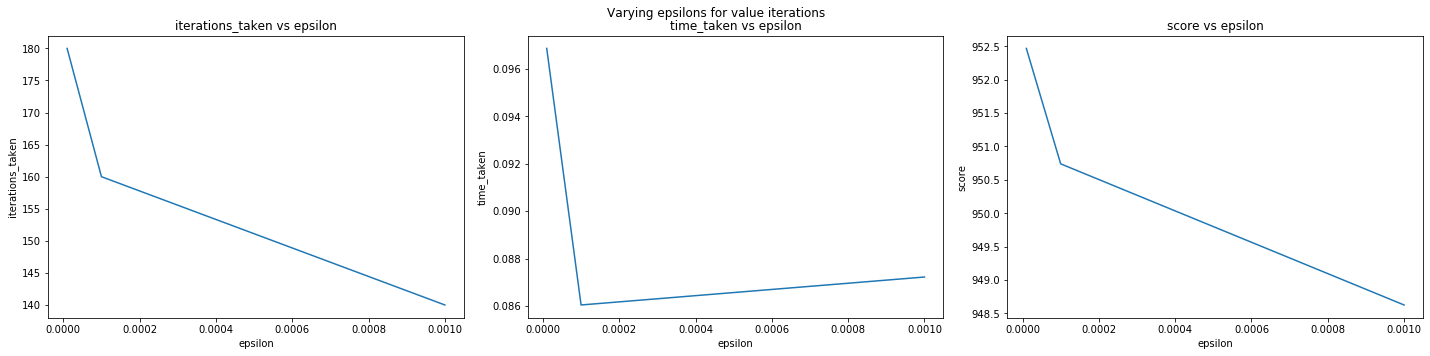

In [8]:
graphs = ['iterations_taken', 'time_taken', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in [0.99]:
    for epsilon in epsilon_list:
        experiment_id = f'gamma={gamma}_epsilon={epsilon}'
        for graph in graphs:
            variables_dict[graph].append(val_iter_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(1,3, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(epsilon_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs epsilon')
    ax.set_xlabel('epsilon')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying epsilons for value iterations')
plt.subplots_adjust(top=0.9)
plt.show()

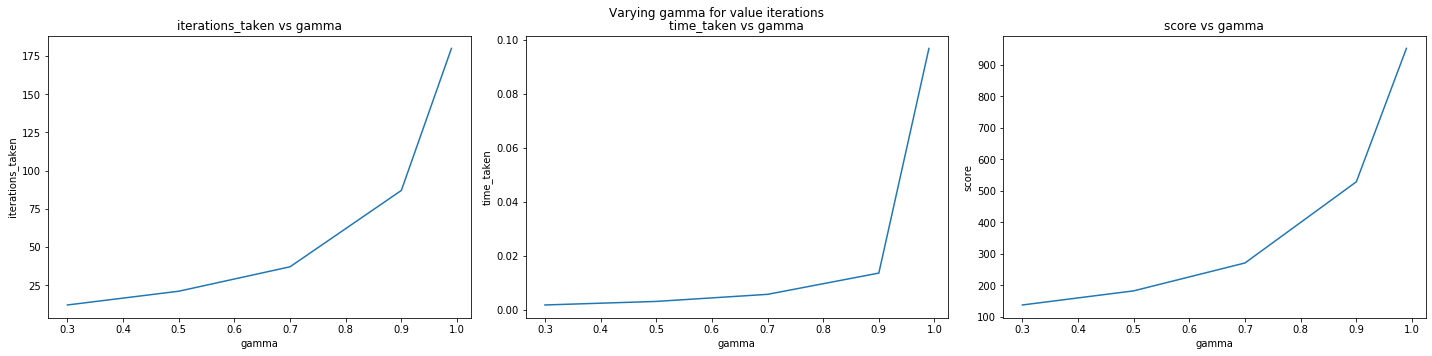

In [9]:
graphs = ['iterations_taken', 'time_taken', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in gamma_list:
    for epsilon in [0.00001]:
        experiment_id = f'gamma={gamma}_epsilon={epsilon}'
        for graph in graphs:
            variables_dict[graph].append(val_iter_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(1,3, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(gamma_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs gamma')
    ax.set_xlabel('gamma')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying gamma for value iterations')
plt.subplots_adjust(top=0.9)
plt.show()

### Policy iteration

In [43]:
policy_iter_perf_dict = {}
best_score = 0
gamma_list = [0.3, 0.5, 0.7, 0.9, 0.99]
for gamma in gamma_list:
    experiment_id = f'gamma={gamma}'

    policy_iteration_mdp = mdptoolbox.mdp.PolicyIteration(transitions, reward_arr, gamma = gamma)
    policy_iteration_mdp.run()
    state_val_arr = np.asarray(policy_iteration_mdp.V)
    policy_arr = np.asarray(policy_iteration_mdp.policy)
    iterations_taken = policy_iteration_mdp.iter
    time_taken = policy_iteration_mdp.time
    max_v = policy_iteration_mdp.run_stats[-1]['Max V']
    summary = experiment_id + f', Policy iteration took {iterations_taken} iterations and {round(time_taken, 5)} seconds, achieved {round(max_v, 2)} max value'
    print(summary)

    experiment_dict = {}
    experiment_dict['state_val_arr'] = state_val_arr
    experiment_dict['policy_arr'] = policy_arr
    experiment_dict['iterations_taken'] = iterations_taken
    experiment_dict['time_taken'] = time_taken
    experiment_dict['score'] = max_v
    experiment_dict['p_cumulative'] = policy_iteration_mdp.p_cumulative
    experiment_dict['error_mean'] = policy_iteration_mdp.error_mean
    experiment_dict['run_stats'] = policy_iteration_mdp.run_stats
    policy_iter_perf_dict[experiment_id] = experiment_dict
    
    with open('forest_policy_iter_output.txt', 'a') as f:
        f.write(summary)

    with open('forest_policy_iter_dict.pickle', 'wb') as handle:
        pickle.dump(policy_iter_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    if max_v > best_score:
        best_score = max_v
        best_params = experiment_id
        
print(f'best params are {best_params}')

gamma=0.3, Policy iteration took 4 iterations and 0.7888 seconds, achieved 137.0 max value
gamma=0.5, Policy iteration took 7 iterations and 1.4907 seconds, achieved 181.87 max value
gamma=0.7, Policy iteration took 12 iterations and 2.3346 seconds, achieved 270.51 max value
gamma=0.9, Policy iteration took 25 iterations and 5.28364 seconds, achieved 528.44 max value
gamma=0.99, Policy iteration took 46 iterations and 9.70264 seconds, achieved 960.23 max value
best params are gamma=0.99


Policy iteration took 46 iterations and 9.70264 seconds, achieved 960.23 max value


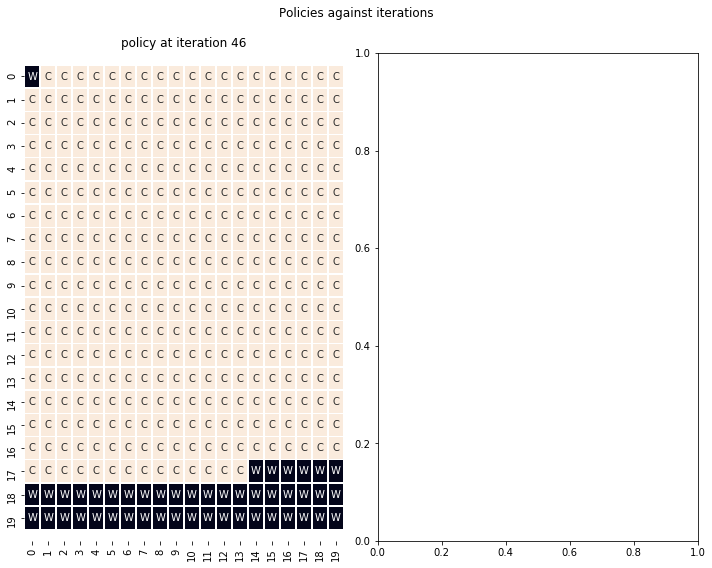

In [44]:
state_val_arr = policy_iter_perf_dict[best_params]['state_val_arr']
policy_arr = policy_iter_perf_dict[best_params]['policy_arr']
iterations_taken = policy_iter_perf_dict[best_params]['iterations_taken']
time_taken = policy_iter_perf_dict[best_params]['time_taken']
max_v = policy_iter_perf_dict[best_params]['run_stats'][-1]['Max V']
print(f'Policy iteration took {iterations_taken} iterations and {round(time_taken, 5)} seconds, achieved {round(max_v, 2)} max value')
plot_policy([policy_arr], [iterations_taken])

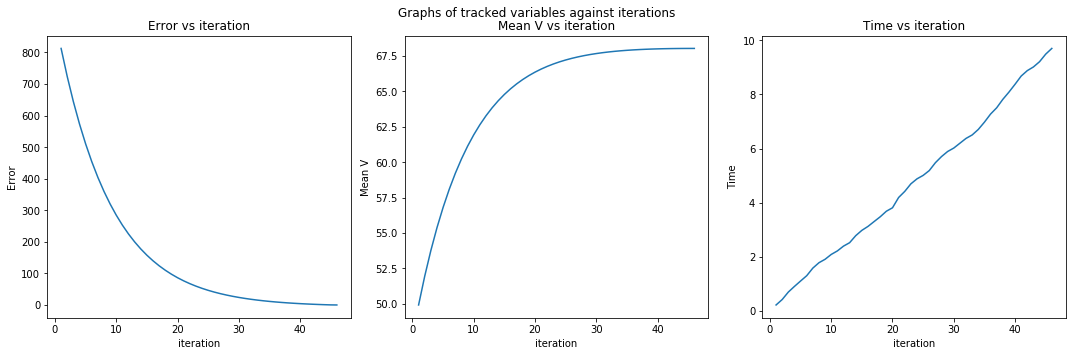

In [73]:
stats_list = policy_iter_perf_dict[best_params]['run_stats']
graphs = ['Error', 'Mean V', 'Time']
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, graph in zip(axes.ravel(), graphs):
    iterations_list = [stats['Iteration'] for stats in stats_list]
    variable_list = [stats[graph] for stats in stats_list]
    ax.plot(iterations_list, variable_list, label=graph)
    ax.title.set_text(f'{graph} vs iteration')
    ax.set_xlabel('iteration')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Graphs of tracked variables against iterations')
plt.subplots_adjust(top=0.9)
plt.show()

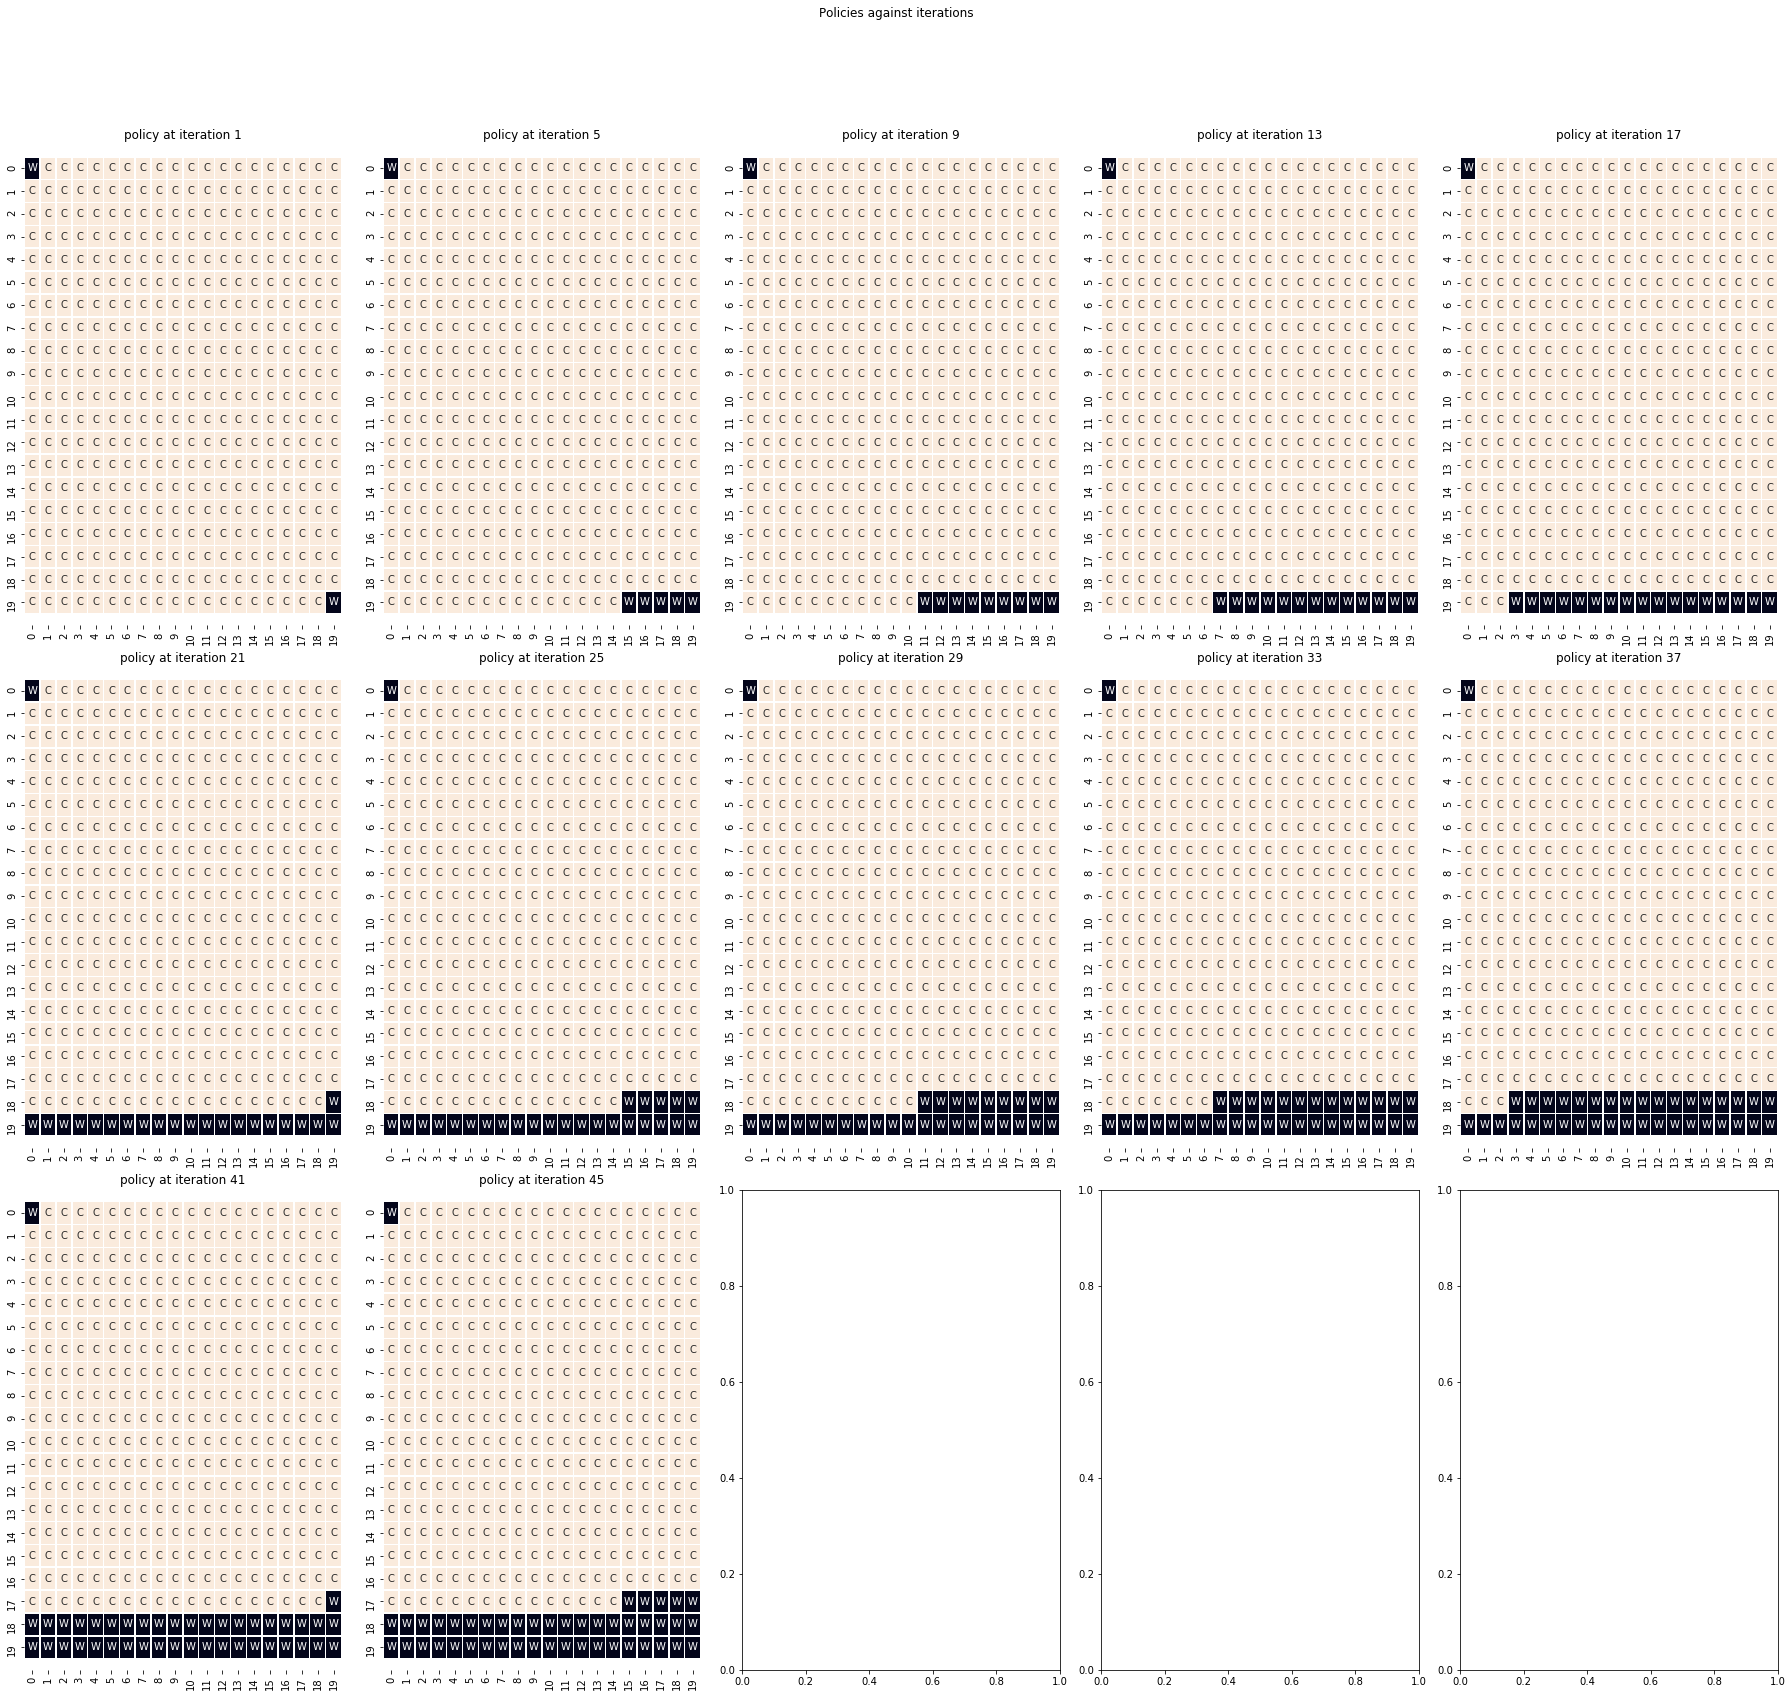

In [46]:
p_cumulative = policy_iter_perf_dict[best_params]['p_cumulative']
length = len(p_cumulative)
every_n = 1 if length // 10 == 0 else length // 10
iterations = []
policy_arrs = []
for idx, p_cum in enumerate(p_cumulative):
    if idx % every_n > 0:
        continue
    iterations.append(p_cum[0])
    policy_arrs.append(p_cum[1])
plot_policy(policy_arrs, iterations)

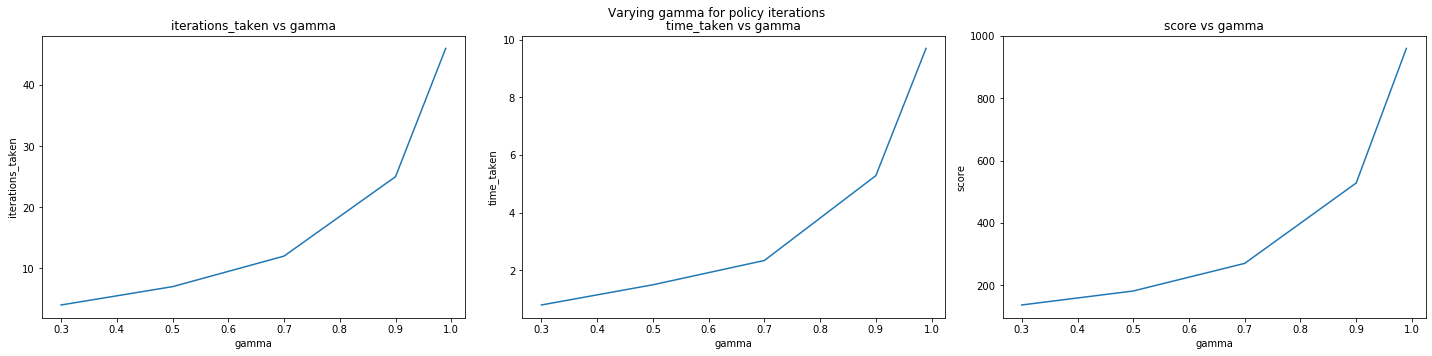

In [47]:
graphs = ['iterations_taken', 'time_taken', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in gamma_list:
    experiment_id = f'gamma={gamma}'
    for graph in graphs:
        variables_dict[graph].append(policy_iter_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(1,3, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(gamma_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs gamma')
    ax.set_xlabel('gamma')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying gamma for policy iterations')
plt.subplots_adjust(top=0.9)
plt.show()

### Q-learning

In [25]:
qlearning_perf_dict = {}
best_score = 0
gamma_list = [0.99, 0.7, 0.5]
n_iter_list = [100000, 1000000, 10000000]
alpha_decay_list = [0.9, 0.99, 0.999]
epsilon_decay_list = [0.9, 0.99, 0.999]
for gamma in gamma_list:
    for n_iter in n_iter_list:
        for alpha_decay in alpha_decay_list:
            for epsilon_decay in epsilon_decay_list:
                experiment_id = f'gamma={gamma}_n_iter={n_iter}_alpha_decay={alpha_decay}_epsilon_decay={epsilon_decay}'
                qlearning_mdp = mdptoolbox.mdp.QLearning(transitions, reward_arr, gamma = gamma, n_iter = n_iter,
                                                         alpha_decay = alpha_decay, epsilon_decay = epsilon_decay)
                qlearning_mdp.run()
                state_val_arr = np.asarray(qlearning_mdp.V)
                policy_arr = np.asarray(qlearning_mdp.policy)
                time_taken = qlearning_mdp.time
                max_v = qlearning_mdp.run_stats[-1]['Max V']
                summary = experiment_id + f', Qlearning took {n_iter} iterations and {round(time_taken, 5)} seconds, achieved {round(max_v, 2)} max value'
                print(summary)
                experiment_dict = {}
                experiment_dict['state_val_arr'] = state_val_arr
                experiment_dict['policy_arr'] = policy_arr
                experiment_dict['iterations_taken'] = n_iter
                experiment_dict['time_taken'] = time_taken
                experiment_dict['score'] = max_v
                experiment_dict['p_cumulative'] = qlearning_mdp.p_cumulative
                experiment_dict['error_mean'] = qlearning_mdp.error_mean
                experiment_dict['run_stats'] = qlearning_mdp.run_stats
                qlearning_perf_dict[experiment_id] = experiment_dict
                
                with open('forest_qlearning_output.txt', 'a') as f:
                    f.write(summary)

                with open('forest_qlearning_dict.pickle', 'wb') as handle:
                    pickle.dump(qlearning_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

                if max_v > best_score:
                    best_score = max_v
                    best_params = experiment_id

print(f'best params are {best_params}')

gamma=0.99_n_iter=100000_alpha_decay=0.9_epsilon_decay=0.9, Qlearning took 100000 iterations and 3.9085 seconds, achieved 17.39 max value
gamma=0.99_n_iter=100000_alpha_decay=0.9_epsilon_decay=0.99, Qlearning took 100000 iterations and 3.85653 seconds, achieved 17.38 max value
gamma=0.99_n_iter=100000_alpha_decay=0.9_epsilon_decay=0.999, Qlearning took 100000 iterations and 3.79554 seconds, achieved 17.35 max value
gamma=0.99_n_iter=100000_alpha_decay=0.99_epsilon_decay=0.9, Qlearning took 100000 iterations and 3.82702 seconds, achieved 17.76 max value
gamma=0.99_n_iter=100000_alpha_decay=0.99_epsilon_decay=0.99, Qlearning took 100000 iterations and 3.80121 seconds, achieved 17.99 max value
gamma=0.99_n_iter=100000_alpha_decay=0.99_epsilon_decay=0.999, Qlearning took 100000 iterations and 3.81429 seconds, achieved 17.78 max value
gamma=0.99_n_iter=100000_alpha_decay=0.999_epsilon_decay=0.9, Qlearning took 100000 iterations and 3.895 seconds, achieved 12.99 max value
gamma=0.99_n_iter=1

Qlearning took 10000000 iterations and 378.14501 seconds, achieved 376.18 max value


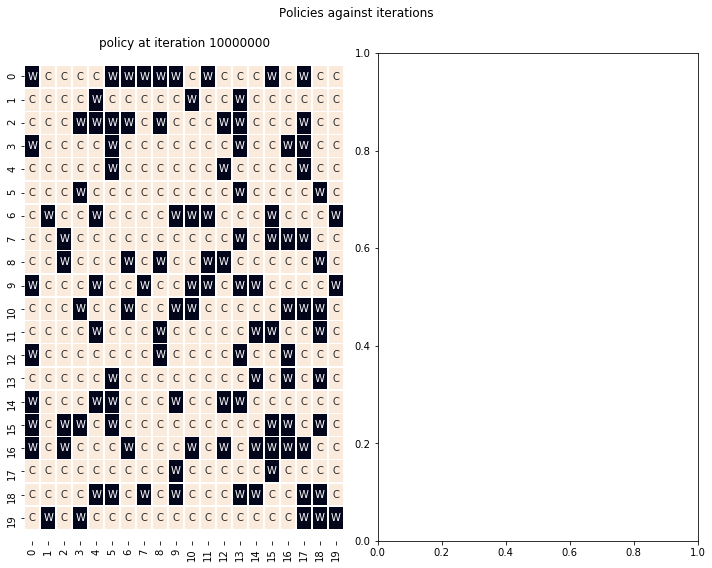

In [28]:
state_val_arr = qlearning_perf_dict[best_params]['state_val_arr']
policy_arr = qlearning_perf_dict[best_params]['policy_arr']
iterations_taken = qlearning_perf_dict[best_params]['iterations_taken']
time_taken = qlearning_perf_dict[best_params]['time_taken']
max_v = qlearning_perf_dict[best_params]['run_stats'][-1]['Max V']
print(f'Qlearning took {iterations_taken} iterations and {round(time_taken, 5)} seconds, achieved {round(max_v, 2)} max value')
plot_policy([policy_arr], [iterations_taken])

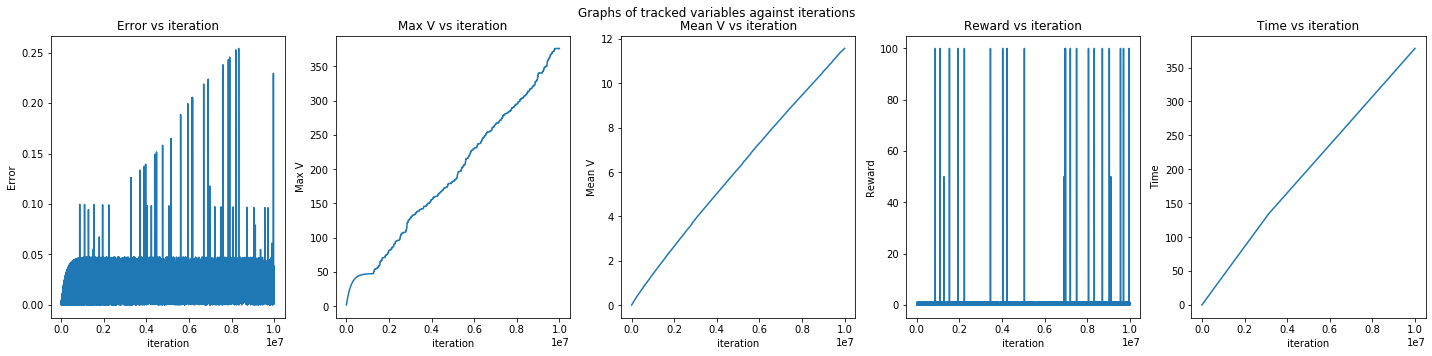

In [29]:
stats_list = qlearning_perf_dict[best_params]['run_stats']
graphs = ['Error', 'Max V', 'Mean V', 'Reward', 'Time']
fig, axes = plt.subplots(1,5, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    iterations_list = [stats['Iteration'] for stats in stats_list]
    variable_list = [stats[graph] for stats in stats_list]
    ax.plot(iterations_list, variable_list, label=graph)
    ax.title.set_text(f'{graph} vs iteration')
    ax.set_xlabel('iteration')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Graphs of tracked variables against iterations')
plt.subplots_adjust(top=0.9)
plt.show()

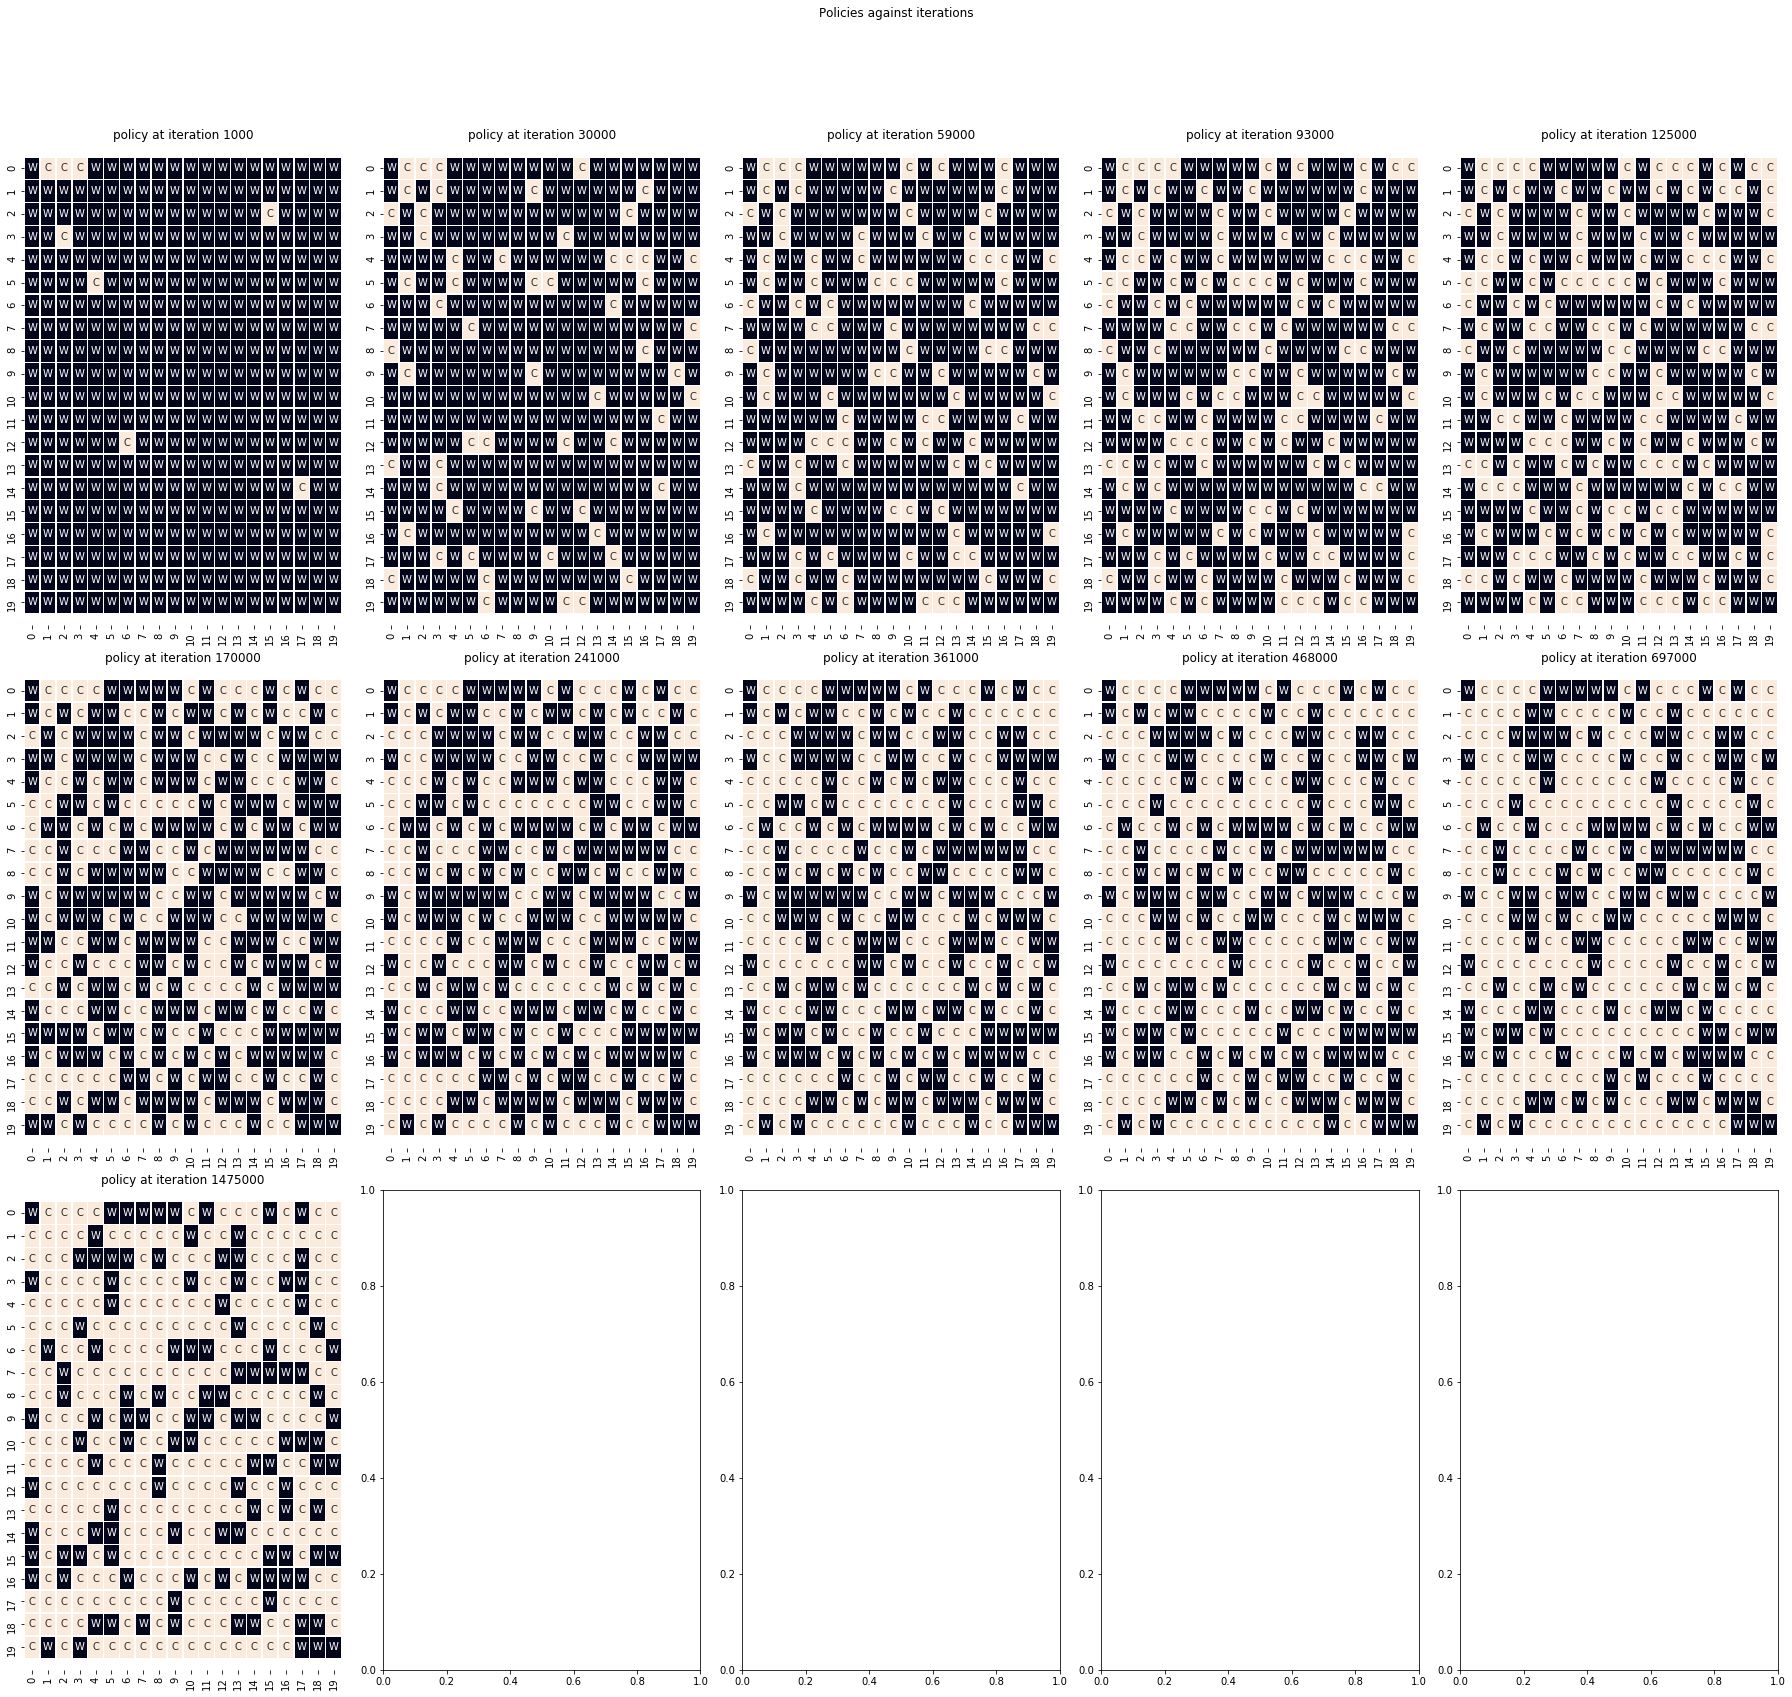

In [30]:
p_cumulative = qlearning_perf_dict[best_params]['p_cumulative']
length = len(p_cumulative)
every_n = 1 if length // 10 == 0 else length // 10
iterations = []
policy_arrs = []
for idx, p_cum in enumerate(p_cumulative):
    if idx % every_n > 0:
        continue
    iterations.append(p_cum[0])
    policy_arrs.append(p_cum[1])
plot_policy(policy_arrs, iterations)

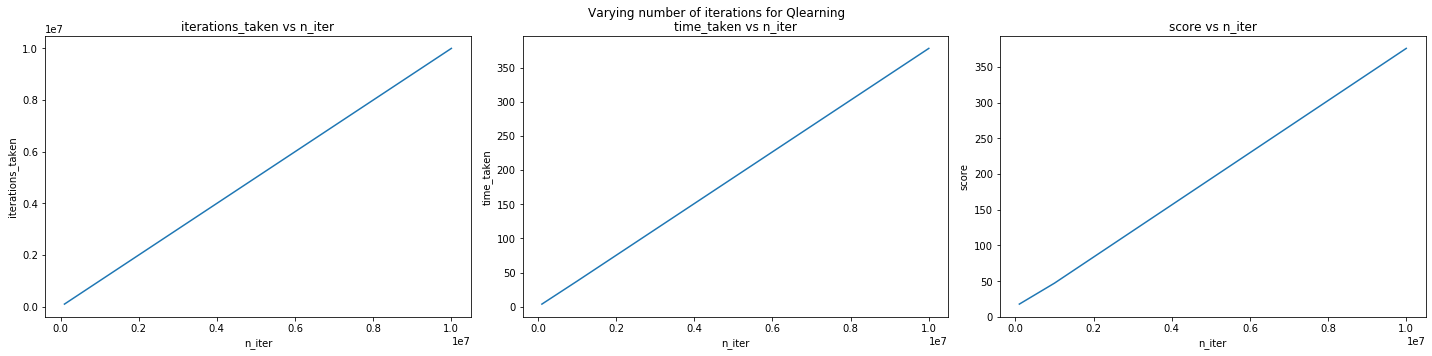

In [27]:
graphs = ['iterations_taken', 'time_taken', 'score']
variables_dict = {graph:[] for graph in graphs}

for gamma in [0.99]:
    for n_iter in n_iter_list:
        for alpha_decay in [0.99]:
            for epsilon_decay in [0.9]:
                experiment_id = f'gamma={gamma}_n_iter={n_iter}_alpha_decay={alpha_decay}_epsilon_decay={epsilon_decay}'
                for graph in graphs:
                    variables_dict[graph].append(qlearning_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(1,3, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(n_iter_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs n_iter')
    ax.set_xlabel('n_iter')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying number of iterations for Qlearning')
plt.subplots_adjust(top=0.9)
plt.show()

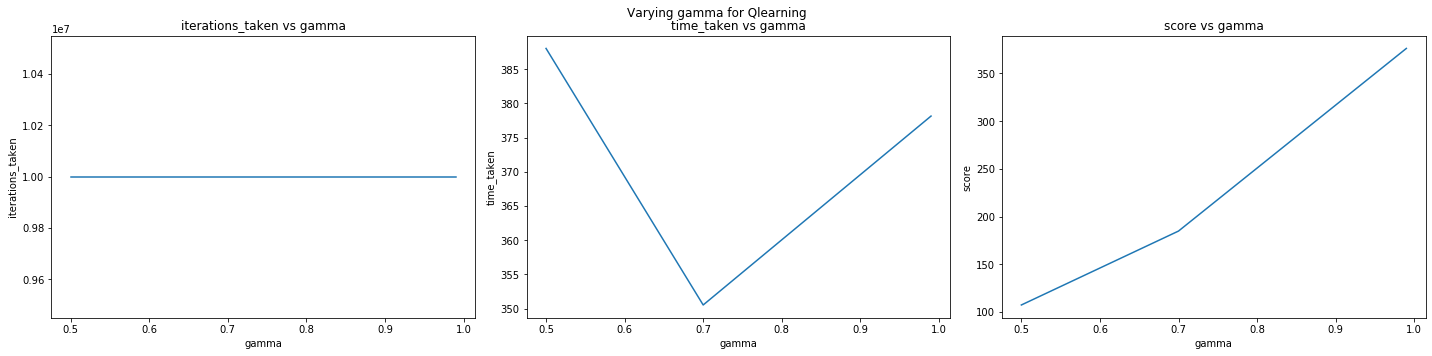

In [31]:
graphs = ['iterations_taken', 'time_taken', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in gamma_list:
    for n_iter in [10000000]:
        for alpha_decay in [0.99]:
            for epsilon_decay in [0.9]:
                experiment_id = f'gamma={gamma}_n_iter={n_iter}_alpha_decay={alpha_decay}_epsilon_decay={epsilon_decay}'
                for graph in graphs:
                    variables_dict[graph].append(qlearning_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(1,3, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(gamma_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs gamma')
    ax.set_xlabel('gamma')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying gamma for Qlearning')
plt.subplots_adjust(top=0.9)
plt.show()

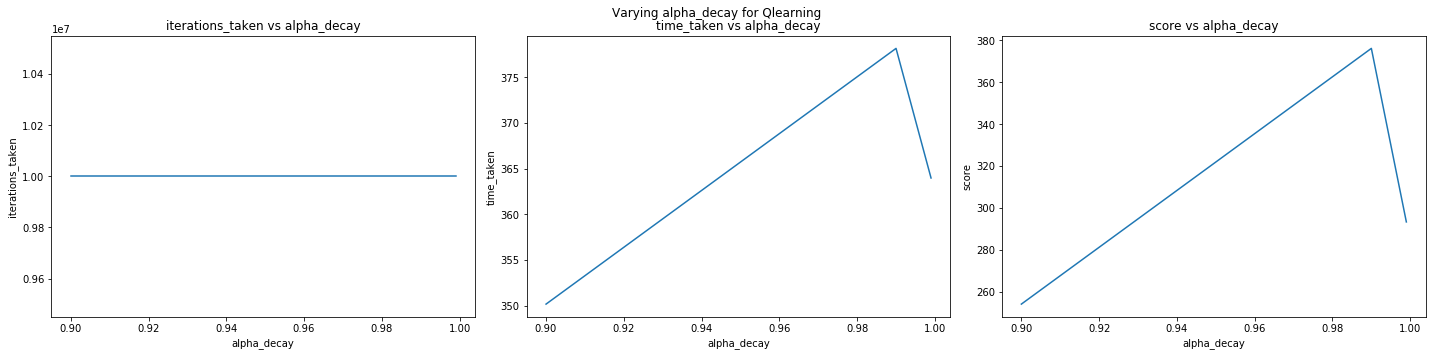

In [32]:
graphs = ['iterations_taken', 'time_taken', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in [0.99]:
    for n_iter in [10000000]:
        for alpha_decay in alpha_decay_list:
            for epsilon_decay in [0.9]:
                experiment_id = f'gamma={gamma}_n_iter={n_iter}_alpha_decay={alpha_decay}_epsilon_decay={epsilon_decay}'
                for graph in graphs:
                    variables_dict[graph].append(qlearning_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(1,3, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(alpha_decay_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs alpha_decay')
    ax.set_xlabel('alpha_decay')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying alpha_decay for Qlearning')
plt.subplots_adjust(top=0.9)
plt.show()

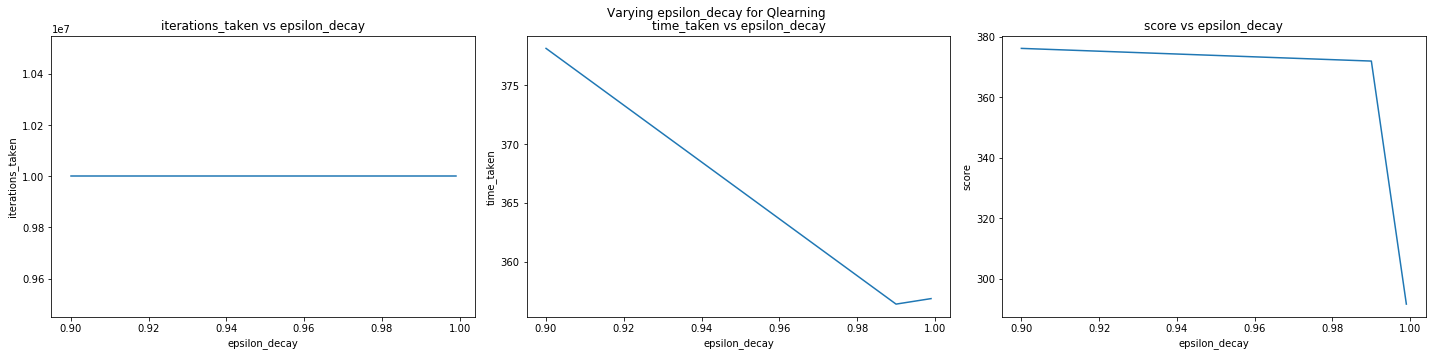

In [33]:
graphs = ['iterations_taken', 'time_taken', 'score']
variables_dict = {graph:[] for graph in graphs}
for gamma in [0.99]:
    for n_iter in [10000000]:
        for alpha_decay in [0.99]:
            for epsilon_decay in epsilon_decay_list:
                experiment_id = f'gamma={gamma}_n_iter={n_iter}_alpha_decay={alpha_decay}_epsilon_decay={epsilon_decay}'
                for graph in graphs:
                    variables_dict[graph].append(qlearning_perf_dict[experiment_id][graph])
        
fig, axes = plt.subplots(1,3, figsize=(20,5))
for ax, graph in zip(axes.ravel(), graphs):
    ax.plot(epsilon_decay_list, variables_dict[graph], label=graph)
    ax.title.set_text(f'{graph} vs epsilon_decay')
    ax.set_xlabel('epsilon_decay')
    ax.set_ylabel(graph)

fig.tight_layout()
plt.suptitle('Varying epsilon_decay for Qlearning')
plt.subplots_adjust(top=0.9)
plt.show()

### Comparing 3 algo

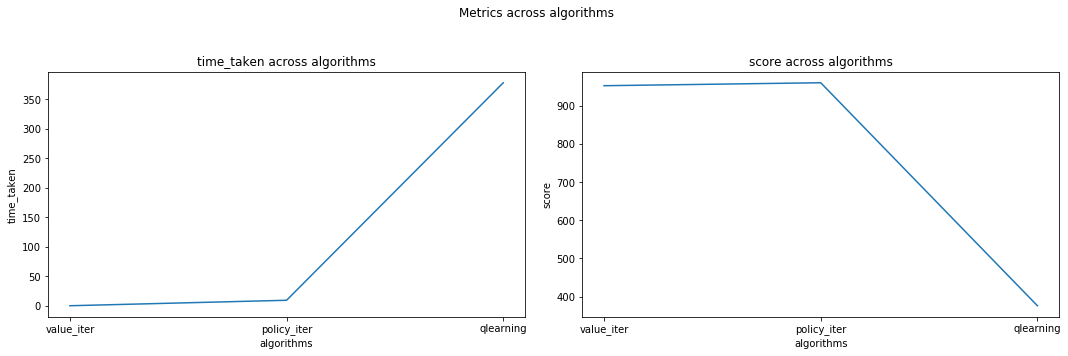

In [39]:
# with open('forest_val_iter_dict.pickle', 'rb') as handle:
#     val_iter_perf_dict = pickle.load(handle)
    
# with open('forest_policy_iter_dict.pickle', 'rb') as handle:
#     policy_iter_perf_dict = pickle.load(handle)
    
# with open('forest_qlearning_dict.pickle', 'rb') as handle:
#     qlearning_perf_dict = pickle.load(handle)

fig, axes = plt.subplots(1,2, figsize=(15,5))
graphs = ['time_taken', 'score']
algos = ['value_iter', 'policy_iter', 'qlearning']
for ax, graph in zip(axes.ravel(), graphs):
    variable_list = []
    for perf_dict in [val_iter_perf_dict, policy_iter_perf_dict, qlearning_perf_dict]:
        best_score = 0
        for exp_id, metrics in perf_dict.items():
            if metrics['score'] >= best_score:
                best_params = exp_id
                best_score = metrics['score']
        best_var = perf_dict[best_params][graph]
        variable_list.append(best_var)
        
    ax.plot(algos, variable_list, label=graph)
    ax.title.set_text(f'{graph} across algorithms')
    ax.set_xlabel('algorithms')
    ax.set_ylabel(graph)
        
    
fig.tight_layout()
plt.suptitle('Metrics across algorithms')
plt.subplots_adjust(top=0.8)
plt.show()